In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt # グラフ描画用
import seaborn as sns; sns.set() # グラフ描画用

In [2]:
train_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")
whole_df = pd.concat([train_df, test_df], ignore_index=True)

In [3]:
whole_df["Publisher"]=whole_df["Publisher"].fillna("Nan")
whole_df["Developer"]=whole_df["Developer"].fillna("Nan")

In [4]:
def preprocess(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()

    idx_tbd = input_df['User_Score'] == 'tbd'
    output_df['User_Score_is_tbd'] = idx_tbd.astype(int)
    output_df['User_Score'] = input_df['User_Score'].replace('tbd', None).astype(float)
    #output_df["User_Score"]=output_df["User_Score"].fillna(output_df["User_Score"].median())
    #output_df["Critic_Score"]=input_df["Critic_Score"].fillna(input_df["Critic_Score"].median())
    #output_df["Critic_Count"]=input_df["Critic_Count"].fillna(input_df["Critic_Count"].median())
    #output_df["User_Count"]=input_df["User_Count"].fillna(input_df["User_Count"].median())
    #output_df["Year_of_Release"]=input_df["Year_of_Release"].fillna(input_df["Year_of_Release"].median())  
    
    #output_df["User_Score"]=output_df["User_Score"].fillna(0)
    #output_df["Critic_Score"]=input_df["Critic_Score"].fillna(0)
    #output_df["Critic_Count"]=input_df["Critic_Count"].fillna(0)
    #output_df["User_Count"]=input_df["User_Count"].fillna(0)
    
    
    f=lambda x:x.fillna(x.mean())
    output_df["Year_of_Release"]=input_df.groupby("Platform")["Year_of_Release"].transform(f)
    output_df["Critic_Score"]=input_df.groupby("Publisher")["Critic_Score"].transform(f)
    output_df["Critic_Count"]=input_df.groupby("Publisher")["Critic_Count"].transform(f)
    output_df["User_Count"]=input_df.groupby("Publisher")["User_Count"].transform(f)
    return output_df

def create_continuous_features(input_df):
    input_df = preprocess(input_df)
    use_columns = [
        # 連続変数
        'Critic_Score',
        'Critic_Count', 
        'User_Score', 
        'User_Count',
        'Year_of_Release',
        'User_Score_is_tbd'
    ]
    return input_df[use_columns].copy()

In [5]:
_whole_df=create_continuous_features(whole_df)
_train_x1=_whole_df.iloc[:train_df.shape[0],:].reset_index(drop=True)
_test_x1=_whole_df.iloc[train_df.shape[0]:,:].reset_index(drop=True)

In [6]:
def frequency_encoding(input_df,all_df=None):
    cat_cols=["Name","Platform","Year_of_Release","Developer"]
    output_df=input_df.copy()
    for c in cat_cols:
        freq=all_df[c].value_counts()
        output_df[c+"2"]=input_df[c].map(freq)
    return output_df[["Name2","Platform2","Year_of_Release2","Developer2"]]

In [7]:
_train_x2=frequency_encoding(train_df,whole_df)
_test_x2=frequency_encoding(test_df,whole_df)
temp_train1=pd.concat([_train_x1,_train_x2],axis=1)
temp_test1=pd.concat([_test_x1,_test_x2],axis=1)

In [8]:
def sum_change(input_df:pd.DataFrame)->pd.DataFrame:
    output_df=pd.DataFrame()
    vc=input_df.sum()>30
    output_df=input_df[vc.index[vc]]
    return output_df

In [9]:
cat_cols=["Platform", "Genre", "Rating"]
all_x=pd.get_dummies(whole_df[cat_cols],columns=cat_cols,dummy_na=True)
all_x=sum_change(all_x)
_train_x3=all_x.iloc[:train_df.shape[0],:].reset_index(drop=True)
_test_x3=all_x.iloc[train_df.shape[0]:,:].reset_index(drop=True)
temp_train2=pd.concat([temp_train1,_train_x3],axis=1)
temp_test2=pd.concat([temp_test1,_test_x3],axis=1)

## PCA

In [10]:
def PCA_chage(whole_df:pd.DataFrame,index:str,columns:str):
    plat_pivot = whole_df.pivot_table(index=index, columns=columns,values='Name', aggfunc='count').reset_index()
    plat_pivot=plat_pivot.fillna(0)
    plat_pivot_ketugou=plat_pivot[[index]]
    pca=PCA(n_components=4)
    pca.fit(plat_pivot.iloc[:,1:])
    _pca=pca.transform(plat_pivot.iloc[:,1:])
    _pca_ketugou=pd.DataFrame(_pca)
    return plat_pivot_ketugou,_pca_ketugou

In [11]:
from sklearn.decomposition import PCA
# 各PublisherのPlatform毎のデータ件数は以下のようにして集計しています。
plat_pivot_ketugou,_pca_ketugou=PCA_chage(whole_df,index="Publisher",columns="Platform")
__train_x4=pd.concat([plat_pivot_ketugou,_pca_ketugou],axis=1)
__test_x4=pd.concat([plat_pivot_ketugou,_pca_ketugou],axis=1)
_train_x4=pd.merge(train_df,__train_x4,on="Publisher")
_train_x4=_train_x4[[0,1,2,3]]
_test_x4=pd.merge(test_df,__test_x4,on="Publisher")
_test_x4=_test_x4[[0,1,2,3]]
temp_train3=pd.concat([temp_train2,_train_x4],axis=1)
temp_test3=pd.concat([temp_test2,_test_x4],axis=1)

## PlatformとGenreを結合

In [12]:
"""
_whole_df["Platform+Genre"]=whole_df["Platform"].str.cat(whole_df["Genre"],sep="+")
cat_cols=["Platform+Genre"]
for c in cat_cols:
    freq=_whole_df[c].value_counts()
    _whole_df[c]=_whole_df[c].map(freq)
_train_x6=_whole_df[["Platform+Genre"]].iloc[:train_df.shape[0],:].reset_index(drop=True)
_test_x6=_whole_df[["Platform+Genre"]].iloc[train_df.shape[0]:,:].reset_index(drop=True)
temp_train5=pd.concat([temp_train4,_train_x6],axis=1)
temp_test5=pd.concat([temp_test4,_test_x6],axis=1)
"""

'\n_whole_df["Platform+Genre"]=whole_df["Platform"].str.cat(whole_df["Genre"],sep="+")\ncat_cols=["Platform+Genre"]\nfor c in cat_cols:\n    freq=_whole_df[c].value_counts()\n    _whole_df[c]=_whole_df[c].map(freq)\n_train_x6=_whole_df[["Platform+Genre"]].iloc[:train_df.shape[0],:].reset_index(drop=True)\n_test_x6=_whole_df[["Platform+Genre"]].iloc[train_df.shape[0]:,:].reset_index(drop=True)\ntemp_train5=pd.concat([temp_train4,_train_x6],axis=1)\ntemp_test5=pd.concat([temp_test4,_test_x6],axis=1)\n'

## 上記に更にYearを結合

In [13]:
_whole_df1=pd.DataFrame()
_whole_df2=pd.DataFrame()
_whole_df3=pd.DataFrame()
_whole_df1["Platform+Genre"]=whole_df["Platform"].str.cat(whole_df["Genre"],sep="+")
_whole_df2["Year"]=pd.cut(whole_df["Year_of_Release"],[1979,1985,1990,1995,2000,2005,2010,2015,2020])

In [14]:
_whole_df2=_whole_df2[["Year"]].astype(str)
_whole_df3["Platform+Genre+Year"]=_whole_df1["Platform+Genre"].str.cat(_whole_df2["Year"],sep="+")
cat_cols=["Platform+Genre+Year"]
for c in cat_cols:
    freq=_whole_df3[c].value_counts()
    _whole_df3[c]=_whole_df3[c].map(freq)
_train_x5=_whole_df3[["Platform+Genre+Year"]].iloc[:train_df.shape[0],:].reset_index(drop=True)
_test_x5=_whole_df3[["Platform+Genre+Year"]].iloc[train_df.shape[0]:,:].reset_index(drop=True)
temp_train4=pd.concat([temp_train3,_train_x5],axis=1)
temp_test4=pd.concat([temp_test3,_test_x5],axis=1)

## シリーズもの

In [15]:
"""
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g , s):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items() if sum_words[0, idx] > s]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=False)
    return words_freq[:n]

tmp=whole_df["Name"].astype("U")
most_common_bi = get_top_text_ngrams(tmp,1000,2,5)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))
plt.show()
whole_df=whole_df[["Name"]].fillna("Nan")
whole_df["num_Series"] = 0
for i in most_common_bi:
    idx = whole_df[whole_df["Name"].str.contains(i)].index
    whole_df.iloc[idx, -1] = most_common_bi[i]
_train_x6=whole_df[["num_Series"]].iloc[:train_df.shape[0],:].reset_index(drop=True)
_test_x6=whole_df[["num_Series"]].iloc[train_df.shape[0]:,:].reset_index(drop=True)
temp_train5=pd.concat([temp_train4,_train_x6],axis=1)
temp_test5=pd.concat([temp_test4,_test_x6],axis=1)
"""

'\nfrom sklearn.feature_extraction.text import CountVectorizer\ndef get_top_text_ngrams(corpus, n, g , s):\n    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)\n    bag_of_words = vec.transform(corpus)\n    sum_words = bag_of_words.sum(axis=0) \n    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items() if sum_words[0, idx] > s]\n    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=False)\n    return words_freq[:n]\n\ntmp=whole_df["Name"].astype("U")\nmost_common_bi = get_top_text_ngrams(tmp,1000,2,5)\nmost_common_bi = dict(most_common_bi)\nsns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))\nplt.show()\nwhole_df=whole_df[["Name"]].fillna("Nan")\nwhole_df["num_Series"] = 0\nfor i in most_common_bi:\n    idx = whole_df[whole_df["Name"].str.contains(i)].index\n    whole_df.iloc[idx, -1] = most_common_bi[i]\n_train_x6=whole_df[["num_Series"]].iloc[:train_df.shape[0],:].reset_index(drop=True)\n_test_x6=whole_df[["num_Series

In [16]:
train_x=temp_train4
test_x=temp_test4
train_x_lgb=train_x
test_x_lgb=test_x

In [17]:
train_y = np.log1p(train_df[["Global_Sales"]])

In [18]:
import lightgbm as lgb

class ModelLGBM:

    def __init__(self, params=None):
        self.model = None
        if params is None:
            self.params = {}
        else:
            self.params = params

    def fit(self, tr_x, tr_y, va_x, va_y,verbose:int=30):
        params = {
            'objective': 'rmse', # 目的関数. これの意味で最小となるようなパラメータを探します. 
            'learning_rate': .1, # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、がそれだけ木を作るため学習に時間がかかります
            'max_depth': 7, # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
            'n_estimators': 1000, # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
            'colsample_bytree': .3, # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
            'importance_type': 'gain' # 特徴重要度計算のロジック(後述)
        }
        params.update(self.params)
        lgb_train = lgb.Dataset(tr_x, tr_y)
        lgb_eval = lgb.Dataset(va_x, va_y)

        num_round = 500
        self.model = lgb.train(params, lgb_train, num_boost_round=num_round,
                               early_stopping_rounds=verbose,
                               valid_names=['train','valid'], valid_sets=[lgb_train, lgb_eval])

    def predict(self, x):
        pred = self.model.predict(x)
        return pred

In [19]:
import xgboost as xgb
from xgboost import XGBRegressor
"""
params = {
            'alpha': 0.006575604800392262,
            'colsample_bytree': 0.65, 
            'gamma': 2.8435713674600754e-06, 
            'lambda': 0.04274832467237334, 
            'max_depth': 8, 
            'min_child_weight': 5.986220700371621,
            'subsample': 0.65
}
"""
params = {
            'alpha': 1.1690581263333025e-07,
            'colsample_bytree': 0.7, 
            'gamma': 1.743935771302139e-08, 
            'lambda': 8.029029787385929e-06, 
            'max_depth': 8, 
            'min_child_weight': 1.2680010472739176,
            'subsample': 0.9
}

class ModelXGB:

    def __init__(self, params=None):
        self.model = None
        if params is None:
            self.params = {}
        else:
            self.params = params

    def fit(self, tr_x, tr_y,va_x=None, va_y=None):
        params = {'objective': 'reg:squarederror', 'silent': 1, 'random_state': 71}
        params.update(self.params)
        num_round = 100
        self.model=XGBRegressor(**params)
        self.model.fit(tr_x,tr_y)
        """
        dtrain = xgb.DMatrix(tr_x, label=tr_y)
        self.model = xgb.train(params, dtrain, num_round)
        """

    def predict(self, x):
        #data = xgb.DMatrix(x)
        #pred = self.model.predict(data)
        pred = self.model.predict(x)
        return pred

In [20]:
class Model2Linear:

    def __init__(self):
        self.model = None
        self.scaler = None

    def fit(self, tr_x, tr_y, va_x, va_y):
        self.scaler = StandardScaler()
        self.scaler.fit(tr_x)
        tr_x = self.scaler.transform(tr_x)
        self.model = LinearRegression()
        self.model.fit(tr_x, tr_y)

    def predict(self, x):
        x = self.scaler.transform(x)
        pred = self.model.predict(x)
        return pred

In [21]:
from sklearn.model_selection import KFold
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_idxes = []

    kf = KFold(n_splits=10, shuffle=True, random_state=71)

    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        model.fit(tr_x, tr_y, va_x, va_y)
        pred = model.predict(va_x)
        preds.append(pred)
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        va_idxes.append(va_idx)

    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]
    
    # テストデータに対する予測値の平均をとる
    preds_test = np.mean(preds_test, axis=0)
    return pred_train, preds_test

In [22]:
model_1a = ModelXGB(params)
pred_train_1a, pred_test_1a = predict_cv(model_1a, train_x, train_y, test_x)

In [23]:
model_1b = ModelLGBM()
pred_train_1b, pred_test_1b = predict_cv(model_1b, train_x_lgb, train_y, test_x_lgb)

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1631
[LightGBM] [Info] Number of data points in the train set: 7523, number of used features: 55
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 3.051505
[1]	train's rmse: 1.34844	valid's 

[9]	train's rmse: 1.12216	valid's rmse: 1.14013
[10]	train's rmse: 1.10057	valid's rmse: 1.12312
[11]	train's rmse: 1.07726	valid's rmse: 1.10214
[12]	train's rmse: 1.06561	valid's rmse: 1.09081
[13]	train's rmse: 1.05321	valid's rmse: 1.0785
[14]	train's rmse: 1.04081	valid's rmse: 1.06743
[15]	train's rmse: 1.02878	valid's rmse: 1.05719
[16]	train's rmse: 1.01705	valid's rmse: 1.04699
[17]	train's rmse: 1.0106	valid's rmse: 1.0422
[18]	train's rmse: 1.00149	valid's rmse: 1.0338
[19]	train's rmse: 0.994315	valid's rmse: 1.02809
[20]	train's rmse: 0.986927	valid's rmse: 1.02195
[21]	train's rmse: 0.982107	valid's rmse: 1.01791
[22]	train's rmse: 0.972788	valid's rmse: 1.01037
[23]	train's rmse: 0.966072	valid's rmse: 1.00398
[24]	train's rmse: 0.959861	valid's rmse: 0.998807
[25]	train's rmse: 0.954598	valid's rmse: 0.994759
[26]	train's rmse: 0.949331	valid's rmse: 0.990929
[27]	train's rmse: 0.943901	valid's rmse: 0.98793
[28]	train's rmse: 0.937342	valid's rmse: 0.984239
[29]	train'

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1625
[LightGBM] [Info] Number of data points in the train set: 7523, number of used features: 55
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 3.043341
[1]	train's rmse: 1.34465	valid's rmse: 1.35475
Training until validation scores don't improve for

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[235]	train's rmse: 0.689312	valid's rmse: 0.893932
[236]	train's rmse: 0.688671	valid's rmse: 0.894024
[237]	train's rmse: 0.688125	valid's rmse: 0.893933
[238]	train's rmse: 0.68769	valid's rmse: 0.893654
[239]	train's rmse: 0.687209	valid's rmse: 0.893891
[240]	train's rmse: 0.686631	valid's rmse: 0.893731
[241]	train's rmse: 0.686077	valid's rmse: 0.893488
[242]	train's rmse: 0.685385	valid's rmse: 0.893515
[243]	train's rmse: 0.684719	valid's rmse: 0.893522
[244]	train's rmse: 0.684149	valid's rmse: 0.893564
[245]	train's rmse: 0.683665	valid's rmse: 0.893612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[246]	train's rmse: 0.683329	valid's rmse: 0.893649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[247]	train's rmse: 0.683055	valid's rmse: 0.893551
[248]	train's rmse: 0.682489	valid's rmse: 0.893539
[249]	train's rmse: 0.68188	valid's rmse: 0.8933

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1622
[LightGBM] [Info] Number of data points in the train set: 7523, number of used features: 55
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 3.031662
[1]	train's rmse: 1.34384	valid's rmse: 1.3578
Training until validation scores don't improve for 

[225]	train's rmse: 0.696328	valid's rmse: 0.896469
[226]	train's rmse: 0.695355	valid's rmse: 0.896751
[227]	train's rmse: 0.694774	valid's rmse: 0.896526
[228]	train's rmse: 0.694027	valid's rmse: 0.896446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[229]	train's rmse: 0.693892	valid's rmse: 0.896471
[230]	train's rmse: 0.693138	valid's rmse: 0.896542
[231]	train's rmse: 0.692666	valid's rmse: 0.896337
[232]	train's rmse: 0.691758	valid's rmse: 0.896274
[233]	train's rmse: 0.690962	valid's rmse: 0.896103
[234]	train's rmse: 0.69014	valid's rmse: 0.895917
[235]	train's rmse: 0.689395	valid's rmse: 0.895682
[236]	train's rmse: 0.688951	valid's rmse: 0.895494
[237]	train's rmse: 0.68835	valid's rmse: 0.895529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[238]	train's rmse: 0.688057	valid's rmse: 0.895456
[239]	train's rmse: 0.687329	valid's rmse: 0.895992
[240]	train's rmse: 0.686641	valid's rmse: 0.895815
[241]	train's rmse: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[245]	train's rmse: 0.688087	valid's rmse: 0.854403
[246]	train's rmse: 0.687733	valid's rmse: 0.854617
[247]	train's rmse: 0.68713	valid's rmse: 0.854415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[248]	train's rmse: 0.686777	valid's rmse: 0.854152
[249]	train's rmse: 0.686075	valid's rmse: 0.854107
[250]	train's rmse: 0.685617	valid's rmse: 0.8538
[251]	train's rmse: 0.685208	valid's rmse: 0.853743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[252]	train's rmse: 0.684988	valid's rmse: 0.853803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[253]	train's rmse: 0.684702	valid's rmse: 0.853501
[254]	train's rmse: 0.684083	valid's rmse: 0.853326
[255]	train's rmse: 0.683457	valid's rmse: 0.853116
[256]	train's rmse: 0.683064	valid's rmse: 0.853217
[257]	train's rmse: 0.682533	valid's rmse: 0.853445
[258]	train's rmse: 0.68177

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 7523, number of used features: 55
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 3.031173
[1]	train's rmse: 1.34816	valid's rmse: 1.3148
Training until validation scores don't improve for 

[225]	train's rmse: 0.694682	valid's rmse: 0.866397
[226]	train's rmse: 0.694058	valid's rmse: 0.866159
[227]	train's rmse: 0.693051	valid's rmse: 0.865997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[228]	train's rmse: 0.69272	valid's rmse: 0.865897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[229]	train's rmse: 0.692584	valid's rmse: 0.865968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[230]	train's rmse: 0.692217	valid's rmse: 0.865888
[231]	train's rmse: 0.691627	valid's rmse: 0.865941
[232]	train's rmse: 0.690927	valid's rmse: 0.865833
[233]	train's rmse: 0.690441	valid's rmse: 0.866282
[234]	train's rmse: 0.689547	valid's rmse: 0.866065
[235]	train's rmse: 0.689022	valid's rmse: 0.866473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[236]	train's rmse: 0.688541	valid's rmse: 0.86671
[237]	train's rmse: 0.688067	valid's rmse: 0.866362
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[254]	train's rmse: 0.675618	valid's rmse: 0.897792
[255]	train's rmse: 0.674413	valid's rmse: 0.897814
[256]	train's rmse: 0.674041	valid's rmse: 0.898055
[257]	train's rmse: 0.673415	valid's rmse: 0.897438
[258]	train's rmse: 0.672799	valid's rmse: 0.89735
[259]	train's rmse: 0.67241	valid's rmse: 0.897168
[260]	train's rmse: 0.671788	valid's rmse: 0.89697
[261]	train's rmse: 0.671081	valid's rmse: 0.896523
[262]	train's rmse: 0.670571	valid's rmse: 0.896462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[263]	train's rmse: 0.670149	valid's rmse: 0.896492
[264]	train's rmse: 0.669667	valid's rmse: 0.896571
[265]	train's rmse: 0.668824	valid's rmse: 0.896821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[266]	train's rmse: 0.668678	valid's rmse: 0.896862
[267]	train's rmse: 0.668323	valid's rmse: 0.896626
[268]	train's rmse: 0.667784	valid's rmse: 0.89627

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1621
[LightGBM] [Info] Number of data points in the train set: 7523, number of used features: 55
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 3.032162
[1]	train's rmse: 1.34135	valid's rmse: 1.38214
Training until validation scores don't improve for

[206]	train's rmse: 0.703833	valid's rmse: 0.894505
[207]	train's rmse: 0.702931	valid's rmse: 0.89463
[208]	train's rmse: 0.702036	valid's rmse: 0.894628
[209]	train's rmse: 0.701514	valid's rmse: 0.894564
[210]	train's rmse: 0.700629	valid's rmse: 0.894676
[211]	train's rmse: 0.699937	valid's rmse: 0.894608
[212]	train's rmse: 0.699601	valid's rmse: 0.894531
[213]	train's rmse: 0.698735	valid's rmse: 0.894129
[214]	train's rmse: 0.698264	valid's rmse: 0.894172
[215]	train's rmse: 0.697629	valid's rmse: 0.893162
[216]	train's rmse: 0.696788	valid's rmse: 0.892656
[217]	train's rmse: 0.696096	valid's rmse: 0.892272
[218]	train's rmse: 0.695372	valid's rmse: 0.892082
[219]	train's rmse: 0.695003	valid's rmse: 0.892181
[220]	train's rmse: 0.694446	valid's rmse: 0.891975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	train's rmse: 0.694318	valid's rmse: 0.892003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[222]	train's rmse:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[251]	train's rmse: 0.681414	valid's rmse: 0.853908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[252]	train's rmse: 0.680978	valid's rmse: 0.853774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[253]	train's rmse: 0.68068	valid's rmse: 0.853661
[254]	train's rmse: 0.680054	valid's rmse: 0.853583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[255]	train's rmse: 0.679917	valid's rmse: 0.853635
[256]	train's rmse: 0.679491	valid's rmse: 0.853431
[257]	train's rmse: 0.678902	valid's rmse: 0.853271
[258]	train's rmse: 0.678216	valid's rmse: 0.853235
[259]	train's rmse: 0.677687	valid's rmse: 0.853373
[260]	train's rmse: 0.677102	valid's rmse: 0.853142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[261]	train's rmse: 0.6767	valid's rmse: 0.853149
[262]	train's rmse: 0.676237	valid's rmse: 0.853183
[Lig

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1625
[LightGBM] [Info] Number of data points in the train set: 7524, number of used features: 55
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 3.031462
[1]	train's rmse: 1.33813	valid's rmse: 1.40783
Training until validation scores don't improve for

[214]	train's rmse: 0.699827	valid's rmse: 0.901744
[215]	train's rmse: 0.699283	valid's rmse: 0.901445
[216]	train's rmse: 0.698503	valid's rmse: 0.90105
[217]	train's rmse: 0.697844	valid's rmse: 0.901082
[218]	train's rmse: 0.697233	valid's rmse: 0.90094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	train's rmse: 0.697189	valid's rmse: 0.900974
[220]	train's rmse: 0.696479	valid's rmse: 0.90063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	train's rmse: 0.696387	valid's rmse: 0.900525
[222]	train's rmse: 0.696	valid's rmse: 0.900548
[223]	train's rmse: 0.694928	valid's rmse: 0.90036
[224]	train's rmse: 0.694227	valid's rmse: 0.900369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[225]	train's rmse: 0.693873	valid's rmse: 0.900238
[226]	train's rmse: 0.693215	valid's rmse: 0.899985
[227]	train's rmse: 0.692516	valid's rmse: 0.900213
[228]	train's rmse: 0.691972	valid's rmse: 0.900388
[L

In [24]:
from sklearn.metrics import mean_squared_error
print(f'rmse: {np.sqrt(mean_squared_error(train_y,pred_train_1a))}')
print(f'rmse: {np.sqrt(mean_squared_error(train_y,pred_train_1b))}')

rmse: 0.8827903778763944
rmse: 0.8795768264442206


In [25]:
# 予測値を特徴量としてデータフレームを作成
train_x_2 = pd.DataFrame({'pred_1a': pred_train_1a, 'pred_1b': pred_train_1b})
test_x_2 = pd.DataFrame({'pred_1a': pred_test_1a, 'pred_1b': pred_test_1b})

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
model_2 = Model2Linear()
pred_train_2, pred_test_2 = predict_cv(model_2, train_x_2, train_y, test_x_2)
print(f'rmse: {np.sqrt(mean_squared_error(train_y,pred_train_2))}')

rmse: 0.8713743029158673


In [27]:
result = np.expm1(pred_test_2)

In [28]:
submission=pd.DataFrame({"Global_Sales":result.flatten()})
submission.to_csv(("submission_second.csv"),index=False)

In [29]:
cols = list(train_x.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(model_1b.model.feature_importance()) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

,feature,importance
3,User_Count,0.093348
1,Critic_Count,0.089959
54,Platform+Genre+Year,0.070188
2,User_Score,0.065527
9,Developer2,0.063550
0,Critic_Score,0.063409
51,1,0.056913
8,Year_of_Release2,0.055501
4,Year_of_Release,0.049852
50,0,0.045897


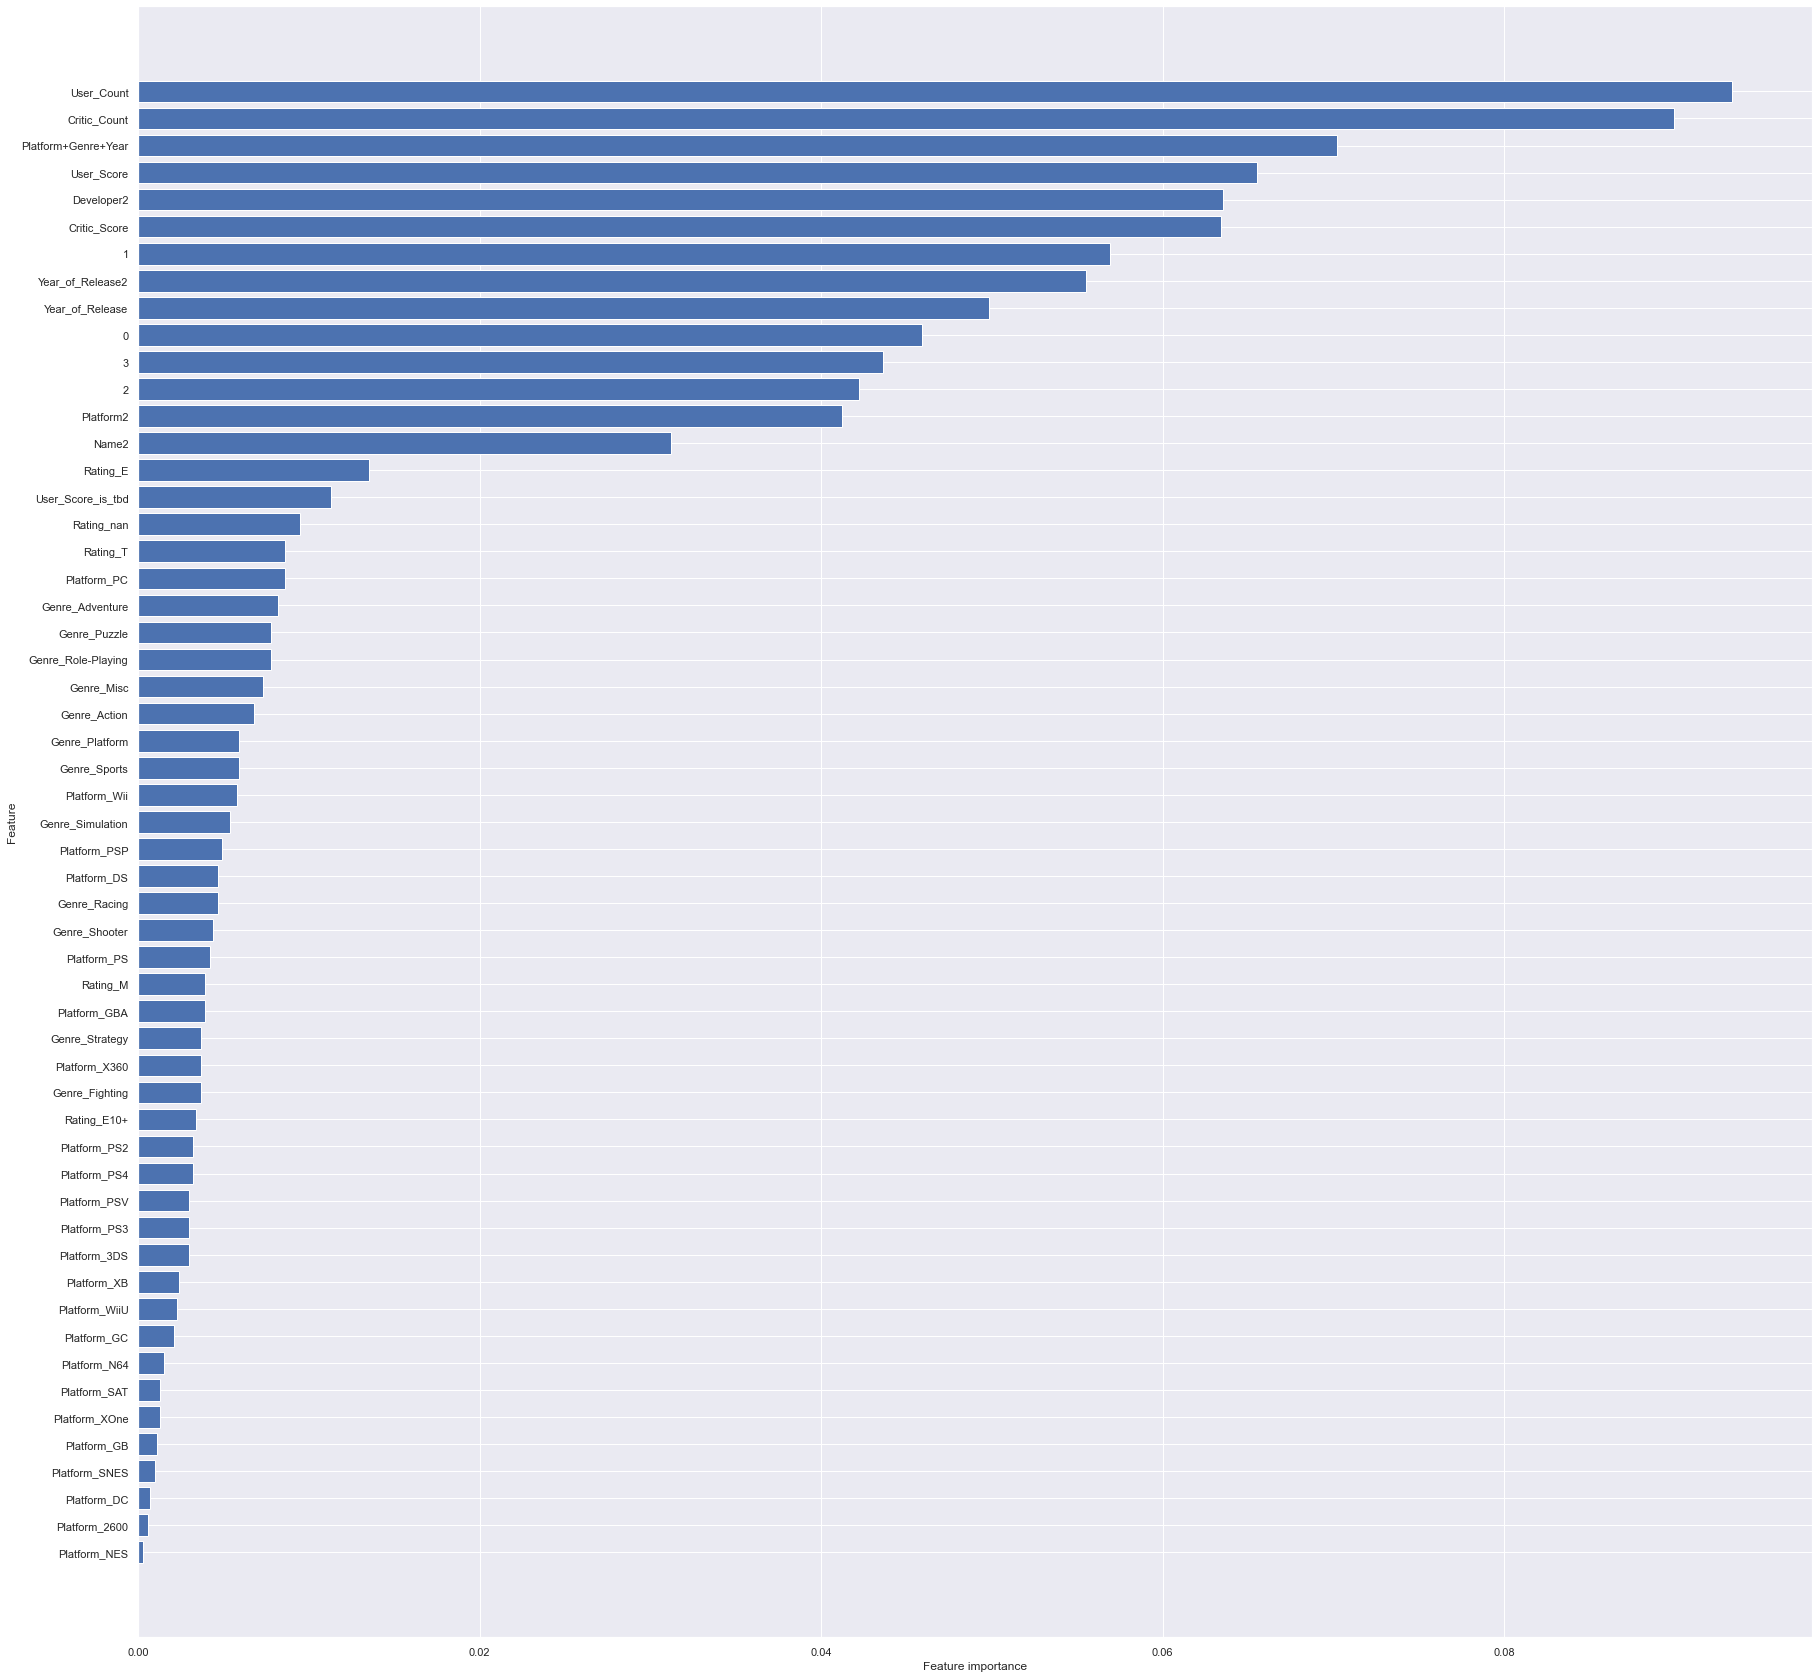

In [30]:
def plot_feature_importance(df): 
    n_features= len(df)                              # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance')            # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_importance_plot = df_plot['importance'].values  # 特徴量重要度の取得 
    plt.figure(figsize=(30,30))
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot['feature'].values   # 特徴量の取得 
    plt.yticks(np.arange(n_features), cols_plot)      # x軸,y軸の値の設定
    plt.xlabel('Feature importance')                  # x軸のタイトル
    plt.ylabel('Feature')  
# 特徴量重要度の可視化
plot_feature_importance(df_importance)